### Sentiment Analysis approach using NaiveBayes

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import warnings
warnings.filterwarnings("ignore")


Bad key text.latex.preview in file c:\Users\rohan\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\rohan\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\rohan\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [5]:
train_tweets = pd.read_csv('./ML Assignment Dataset - Train.csv')
test_tweets = pd.read_csv('./ML Assignment Dataset - Test.csv')

In [6]:
train_tweets.rename(columns={'emotion_in_tweet_is_directed_at': 'brand_chosen', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

def map_to_categories(label):
    if label in ['Negative emotion', 'negative']:
        return 'negative'
    elif label in ['Positive emotion', 'positive']:
        return 'positive'
    else:  # Includes 'No emotion toward brand or product', 'I can't tell', and other unspecified labels
        return 'neutral'

train_tweets['emotion'] = train_tweets['emotion'].apply(map_to_categories)

In [7]:
train_tweets.head()

,tweet_text,brand_chosen,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive


In [8]:
train_tweets.shape

(8589, 3)

In [9]:
train_tweets.isna().sum()

tweet_text         1
brand_chosen    5298
emotion            0
dtype: int64

In [10]:
# train_tweets = train_tweets.dropna(subset=['brand_chosen'])
# Later on I decide not to drop the rows with missing values but use oversampling technique to fix data imbalance 

In [11]:
train_tweets.shape

(8589, 3)

In [12]:
train_tweets.isna().sum()

tweet_text         1
brand_chosen    5298
emotion            0
dtype: int64

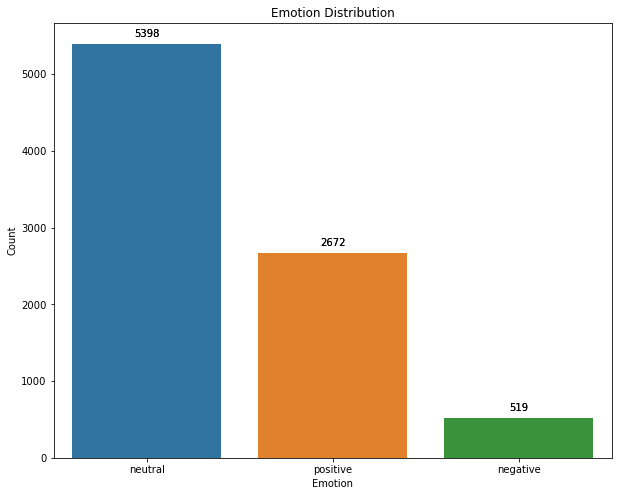

In [13]:
emotion_counts = train_tweets['emotion'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
ax_emotion = sns.barplot(x=emotion_counts.index, y=emotion_counts.values)

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')

for p in ax_emotion.patches:
    ax_emotion.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()

In [14]:
test_tweets.head()

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1,Again? RT @mention Line at the Apple store is ...
2,Boooo! RT @mention Flipboard is developing an ...
3,Thanks to @mention for publishing the news of ...
4,���@mention &quot;Apple has opened a pop-up st...


In [15]:
train_tweets.emotion.value_counts()

neutral     5398
positive    2672
negative     519
Name: emotion, dtype: int64

In [16]:
train_tweets = train_tweets[['tweet_text','emotion']]
# test_tweets = test_tweets['Tweet']

### Some basic EDA

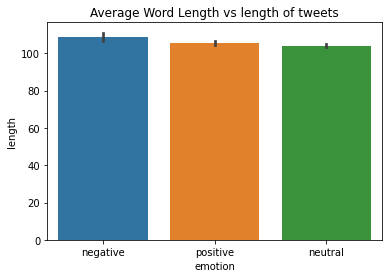

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

train_tweets['tweet_text'] = train_tweets['tweet_text'].astype(str)
train_tweets['length'] = train_tweets['tweet_text'].apply(len)

fig1 = sns.barplot('emotion', 'length', data=train_tweets)
plt.title('Average Word Length vs length of tweets')
plt.show()

plot = fig1.get_figure()
plot.savefig('Barplot.png')


### Feature Engineering

In [18]:
def text_processing(tweet):
    
    # Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    # Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    # Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [19]:
train_tweets['tweet_list'] = train_tweets['tweet_text'].apply(text_processing)
test_tweets['tweet_list'] = test_tweets['Tweet'].apply(text_processing)

In [20]:
train_tweets.head()

,tweet_text,emotion,length,tweet_list
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive,139,"[jessedee, Know, fludapp, Awesome, app, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,positive,79,"[swonderlin, wait, iPad, also, sale, SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,negative,82,"[sxsw, hope, year, festival, crashy, year, iPh..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive,131,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ..."


In [21]:
train_tweets['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [22]:
train_tweets['tweet_list'][0]

['iPhone',
 'hrs',
 'tweet',
 'RISE_Austin',
 'dead',
 'need',
 'upgrade',
 'Plugin',
 'station',
 'SXSW']

### Handling data imbalance

In [23]:
# Count of each emotion
emotion_counts = train_tweets['emotion'].value_counts()
print(emotion_counts)

neutral     5398
positive    2672
negative     519
Name: emotion, dtype: int64


In [24]:
import pandas as pd

# Assuming emotion_counts is obtained from train_tweets['emotion'].value_counts()
target_count = emotion_counts.max()

# Separate the majority and minority classes
df_majority = train_tweets[train_tweets['emotion'] == 'neutral']
df_minority_positive = train_tweets[train_tweets['emotion'] == 'positive']
df_minority_negative = train_tweets[train_tweets['emotion'] == 'negative']

# Oversample minority classes
df_minority_positive_upsampled = df_minority_positive.sample(target_count, replace=True, random_state=42)
df_minority_negative_upsampled = df_minority_negative.sample(target_count, replace=True, random_state=42)

# Combine the majority class with the upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_positive_upsampled, df_minority_negative_upsampled])

# Check new class counts
print(df_upsampled['emotion'].value_counts())

neutral     5398
positive    5398
negative    5398
Name: emotion, dtype: int64


In [25]:
df_upsampled.shape

(16194, 4)

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_upsampled['tweet_text']
y = df_upsampled['emotion']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

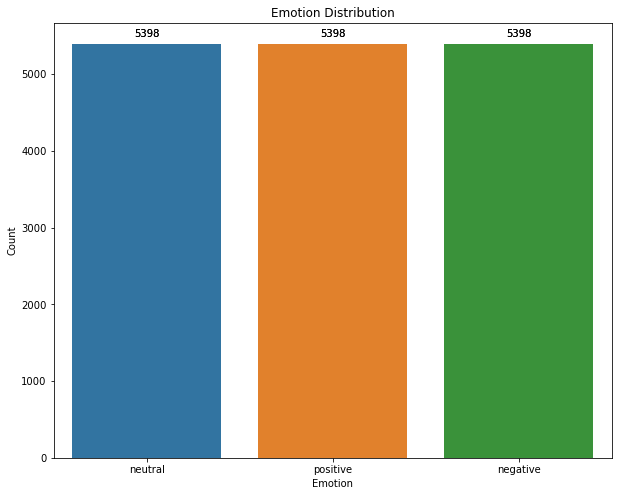

In [27]:
emotion_counts = df_upsampled['emotion'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
ax_emotion = sns.barplot(x=emotion_counts.index, y=emotion_counts.values)

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')

for p in ax_emotion.patches:
    ax_emotion.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()


In [28]:
# doing train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Model Selection and Machine Learning

In [29]:
#Machine Learning Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x000002169AFB6790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [30]:
predictions = pipeline.predict(X_test)

print(classification_report(predictions,y_test))
print ('\n')
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

    negative       0.96      0.85      0.90      1272
     neutral       0.58      0.79      0.66       783
    positive       0.80      0.70      0.75      1184

    accuracy                           0.78      3239
   macro avg       0.78      0.78      0.77      3239
weighted avg       0.81      0.78      0.79      3239



[[1080  125   67]
 [  29  617  137]
 [  19  331  834]]
0.7814140166718123


In [31]:
import pickle

with open('NBpipeline.pickle','wb') as f:
    pickle.dump(pipeline, f)

with open('NBpipeline.pickle', 'rb') as f:
    loaded_pipe = pickle.load(f)
    
predictions_loaded = pipeline.predict(X_test)

print(classification_report(predictions_loaded,y_test))
print ('\n')
print(confusion_matrix(predictions_loaded,y_test))
print(accuracy_score(predictions_loaded,y_test))

              precision    recall  f1-score   support

    negative       0.96      0.85      0.90      1272
     neutral       0.58      0.79      0.66       783
    positive       0.80      0.70      0.75      1184

    accuracy                           0.78      3239
   macro avg       0.78      0.78      0.77      3239
weighted avg       0.81      0.78      0.79      3239



[[1080  125   67]
 [  29  617  137]
 [  19  331  834]]
0.7814140166718123


In [32]:
from joblib import dump
dump(pipeline, 'wysa_model.joblib')

['wysa_model.joblib']

In [36]:
import pickle

with open('NBpipeline.pickle', 'rb') as f:
    loaded_pipe = pickle.load(f)

def predict_sentiment(text):
    if not isinstance(text, str):
        raise ValueError("Input should be a string")

    return loaded_pipe.predict([text])[0]

sample_text = "hi"

predicted_sentiment = predict_sentiment(sample_text)
print(f"The predicted sentiment for the text is: {predicted_sentiment}")

The predicted sentiment for the text is: neutral


In [ ]:
from joblib import load
pipeline_saved = load('wysa_model.joblib')

def predict_sentiment(text):
    if not isinstance(text, str):
        raise ValueError("Input should be a string")

    return pipeline_saved.predict([text])[0]

sample_text = "I am happy"

predicted_sentiment = predict_sentiment(sample_text)
print(f"The predicted sentiment for the text is: {predicted_sentiment}")

### Sentiment Analysis approach using RoBERTa

In [260]:
#RoBERTa Model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

#natural language tool kit
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [261]:
model_name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [262]:
example = df_upsampled['tweet_text'][1]
print(example)

@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW


In [263]:
#VADER Results on example
print(example)

sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example)

@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW


{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'compound': 0.91}

In [264]:
encoded_text = tokenizer(example, return_tensors='pt') 
encoded_text

{'input_ids': tensor([[    0,  1039,   267, 18502,  1942, 10690,    59,   787,  4825,  1906,
          3340, 17487, 40136,  9481,    73, 43688,  1553,    14,    47,   581,
           533,  5478,    13,    63,  1521,     4,  1578,     6,    51,   214,
          1311,   481,  7303,    23,   849,   104,  1000, 11871,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [265]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.9300, -0.2794,  3.8907]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [266]:
scores = output[0][0].detach().numpy()
scores = softmax(scores) 
scores_dict = {
    'roberta_pos': scores[0],
    'roberta_neu': scores[1],
    'roberta_neg': scores[2],
}
scores_dict

{'roberta_pos': 0.0010732715,
 'roberta_neu': 0.015200193,
 'roberta_neg': 0.98372656}

In [267]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
    }
    
    return scores_dict

In [268]:
df_upsampled.head()

,tweet_text,emotion,length,tweet_list
5,@teachntech00 New iPad Apps For #SpeechTherapy...,neutral,140,"[New, iPad, Apps, SpeechTherapy, Communication..."
6,nan,neutral,3,[nan]
16,Holler Gram for iPad on the iTunes App Store -...,neutral,92,"[Holler, Gram, iPad, iTunes, App, Store, http,..."
32,"Attn: All #SXSW frineds, @mention Register fo...",neutral,99,"[Attn, SXSW, frineds, mention, Register, GDGTL..."
33,Anyone at #sxsw want to sell their old iPad?,neutral,45,"[Anyone, sxsw, want, sell, old, iPad]"


In [269]:
from tqdm.notebook import tqdm

results = {}
for idx, row in tqdm(df_upsampled.iterrows(), total=len(df_upsampled)):
    
    text = row['tweet_text']

    #Roberta Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    polarity_result = sia.polarity_scores(text)    
    polarity_result_rename = {}
    for key, value in polarity_result.items():
        polarity_result_rename[f'roberta_{key}'] = value

    #making predictions using roberta model
    roberta_result = polarity_scores_roberta(text)

    #combine both results 
    result = {**polarity_result_rename, **roberta_result}
    results[idx] = result

  0%|          | 0/16194 [00:00<?, ?it/s]

In [270]:
results_df = pd.DataFrame(results).T
results_df = results_df.merge(df_upsampled, how = 'left', right_index=True, left_index=True)
results_df.head()

,roberta_neg,roberta_neu,roberta_pos,roberta_compound,tweet_text,emotion,length,tweet_list
0,0.445089,0.38701,0.167901,-0.68,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."
0,0.445089,0.38701,0.167901,-0.68,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."
0,0.445089,0.38701,0.167901,-0.68,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."
0,0.445089,0.38701,0.167901,-0.68,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."
0,0.445089,0.38701,0.167901,-0.68,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,127,"[iPhone, hrs, tweet, RISE_Austin, dead, need, ..."


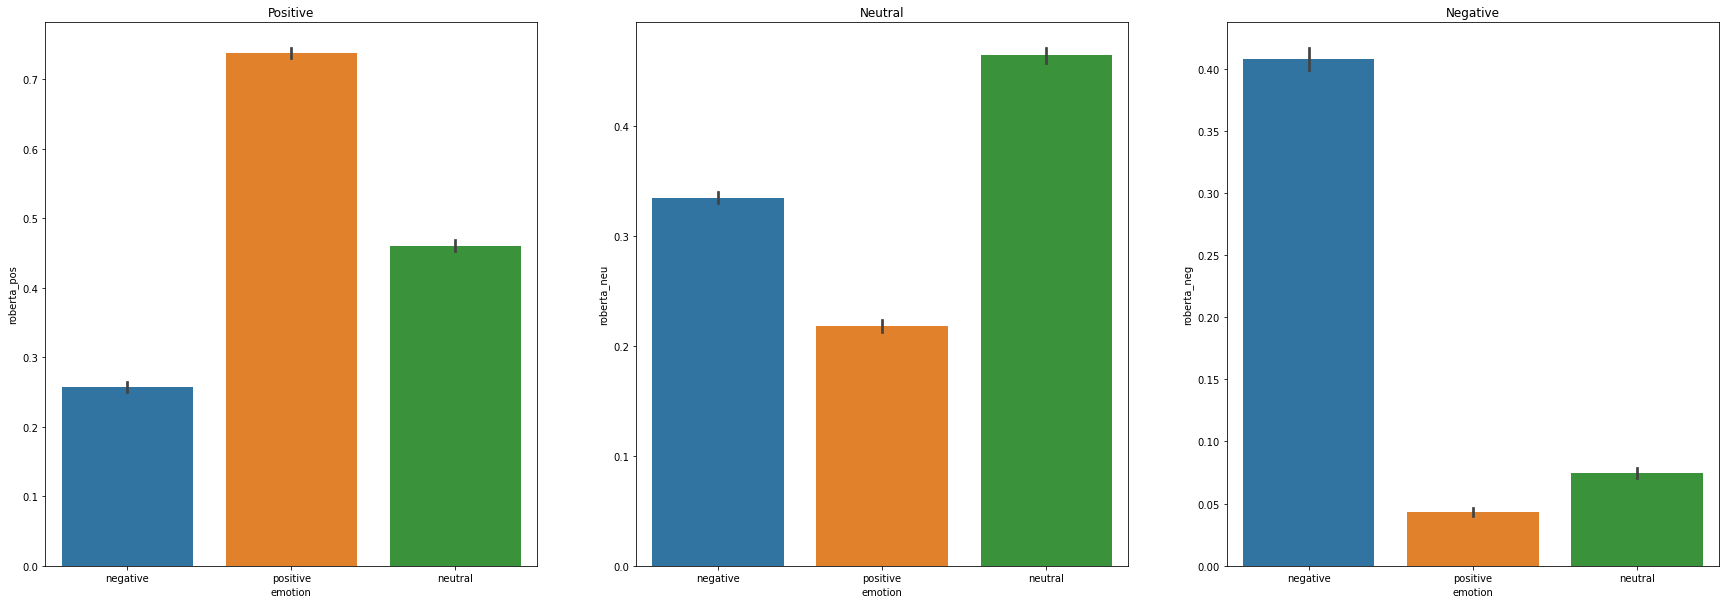

In [272]:
# Plot Roberta results
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=results_df, x='emotion', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='emotion', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='emotion', y='roberta_neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()